Preprocess Operating Room Pictures

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to: /Users/paolabarrios/GenAI_Image/Face-Detection-(Operating-Room)-1
Checking Roboflow dataset structure...
Contents of /Users/paolabarrios/GenAI_Image/Face-Detection-(Operating-Room)-1:
  📄 README.roboflow.txt
  📁 valid/
    Contents of /Users/paolabarrios/GenAI_Image/Face-Detection-(Operating-Room)-1/valid:
      📄 _annotations.coco.json
      📄 000038_jpg.rf.d2610f1ed9d1571514162875477b6c0b.jpg
      📄 111114-2_jpg.rf.be9eee501c82a0655c9b06f544013f2e.jpg
      📄 WebsiteWebP_M-FSURG_Main-Visual_Cyan_Website_jpg.rf.0edad6f608868fd0ad9293a85c431c49.jpg
      📄 333167_jpg.rf.4544c69c3f3a57abcb05a73f1f43e0cf.jpg
      📄 333159_jpg.rf.22bcbeea7ff247d9ca2398ae5dc2b2dc.jpg
      📄 000034_jpg.rf.2431c40ad24dc2a1f38b5f49516d5068.jpg
      📄 team-surgery_jpg.rf.cff2e391d7187a1186eee4fd07621e5b.jpg
      📄 images_jpeg.rf.b899d0851636b98b2c5a2c662b3e8aa9.jpg
      📄 333196_jpg.rf.ffb8f8ebf58df289c020220b89ab64ca.jpg
  

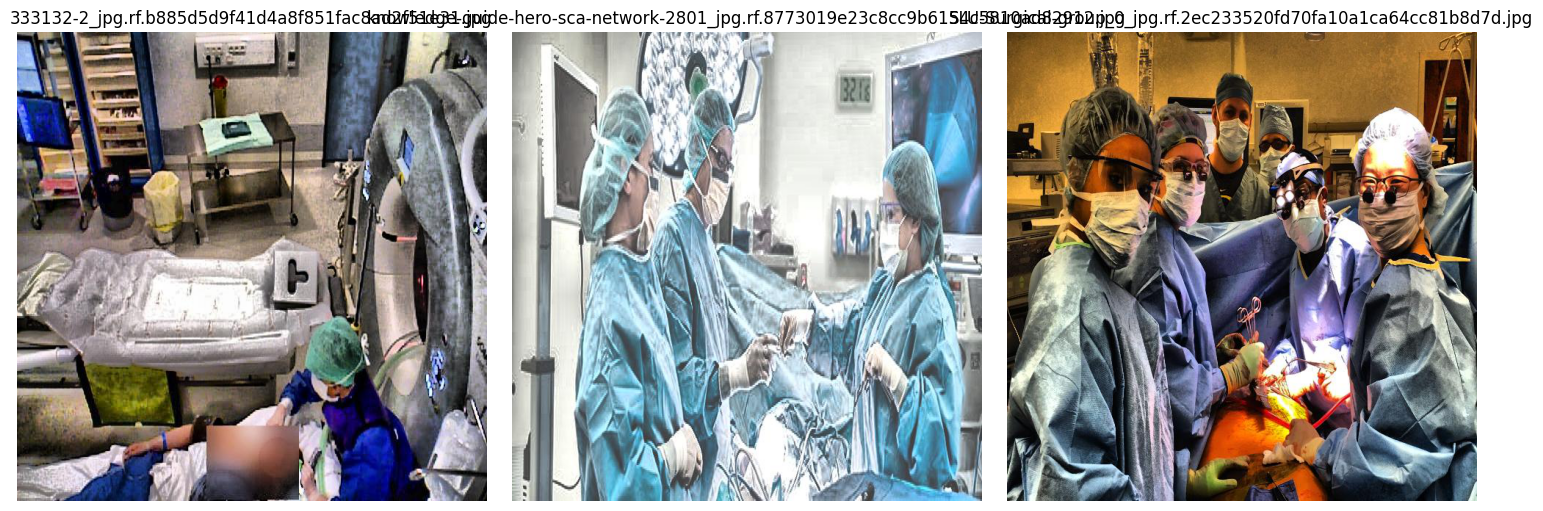


Analyzing Roboflow dataset structure...
Dataset root: /Users/paolabarrios/GenAI_Image/Face-Detection-(Operating-Room)-1
Files by extension:
  .txt: 2
  .json: 2
  .jpg: 270
Found 2 annotation files
Found COCO annotation file: /Users/paolabarrios/GenAI_Image/Face-Detection-(Operating-Room)-1/valid/_annotations.coco.json
COCO annotations contain 30 images and 48 annotations
Processing 216 training images...


100%|██████████| 216/216 [00:01<00:00, 128.49it/s]


Processing 54 test images...


100%|██████████| 54/54 [00:00<00:00, 132.47it/s]


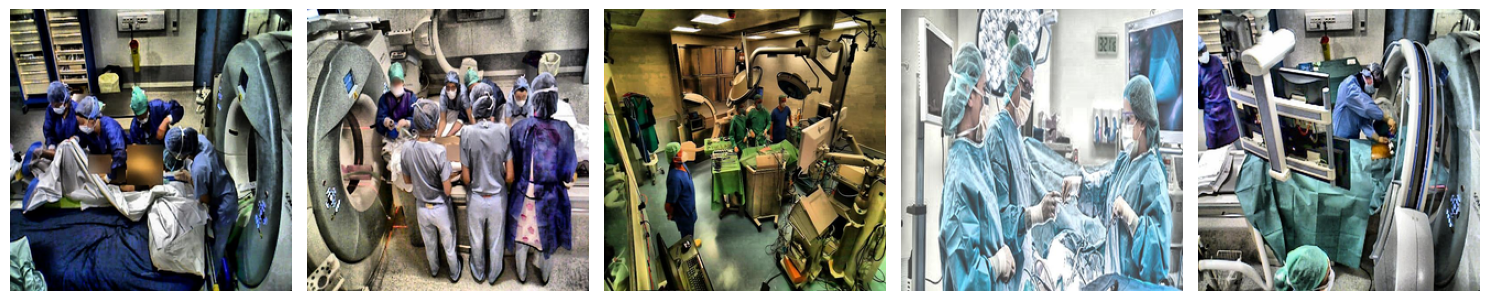

Training images: 216
Test images: 54
Preprocessing complete. Images saved to preprocessed_or_images


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import json
import shutil
from roboflow import Roboflow

# Code provided by Roboflow to load dataset
rf = Roboflow(api_key="uZvyIP0TCztJgFW16Gr2")
project = rf.workspace("paob").project("face-detection-operating-room-v9hko")
version = project.version(1)
dataset = version.download("coco")
input_dir = dataset.location 
print(f"Dataset downloaded to: {input_dir}")

# Check structure
print("Checking Roboflow dataset structure...")
def list_directory_contents(dir_path, indent=0):
    """List all files and directories at the given path with indentation"""
    if not os.path.exists(dir_path):
        print(" " * indent + f"Directory not found: {dir_path}")
        return
    
    print(" " * indent + f"Contents of {dir_path}:")
    for item in os.listdir(dir_path):
        item_path = os.path.join(dir_path, item)
        if os.path.isdir(item_path):
            print(" " * (indent + 2) + f"📁 {item}/")
            # Only go one level deep to avoid too much output
            if indent < 2:  
                list_directory_contents(item_path, indent + 4)
        else:
            print(" " * (indent + 2) + f"📄 {item}")

list_directory_contents(input_dir)

# Define output directories
output_dir = "preprocessed_or_images"
os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to find image directories in the COCO dataset
def find_image_directories(dataset_dir):
    """Find directories containing images in the COCO dataset structure"""
    image_dirs = []
    potential_dirs = ["train", "valid", "test", "images"]
    
    # Direct check for known directory names
    for dir_name in potential_dirs:
        dir_path = os.path.join(dataset_dir, dir_name)
        if os.path.isdir(dir_path):
            image_dirs.append(dir_path)
    
    # If no known directories found, search recursively
    if not image_dirs:
        for root, dirs, files in os.walk(dataset_dir):
            if any(file.lower().endswith(('.jpg', '.jpeg', '.png')) for file in files):
                image_dirs.append(root)
    
    return image_dirs

# Find image directories
image_dirs = find_image_directories(input_dir)
print(f"Found {len(image_dirs)} directories with images:")
for dir_path in image_dirs:
    print(f"  - {dir_path}")

# Function to preprocess and resize images
# This should match the preprocessing done to the paintings for consistency
def preprocess_image(image_path, target_size=(256, 256)):
    try:
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(target_size, Image.LANCZOS)
        img_array = np.array(img)
        
        return img_array, True
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, False

# Parse COCO annotations to get images
print("Processing Roboflow COCO dataset...")

# Look for COCO annotation file
coco_annotation_file = None
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('_annotations.coco.json'):
            coco_annotation_file = os.path.join(root, file)
            break
    if coco_annotation_file:
        break

# Get all images from all image directories
image_files = []
for image_dir in image_dirs:
    print(f"Scanning for images in {image_dir}...")
    for file in os.listdir(image_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(image_dir, file))

print(f"Found {len(image_files)} images in the Roboflow dataset")

# Try to get image paths from COCO annotation file if available
if coco_annotation_file and len(image_files) == 0:
    print(f"Using COCO annotation file: {coco_annotation_file}")
    try:
        with open(coco_annotation_file, 'r') as f:
            coco_data = json.load(f)
        
        # Extract image paths
        image_dirs_set = set(image_dirs)
        for img_info in coco_data.get('images', []):
            file_name = img_info.get('file_name')
            if file_name:
                # Try to find the image in the dataset
                for image_dir in image_dirs_set:
                    potential_path = os.path.join(image_dir, file_name)
                    if os.path.exists(potential_path):
                        image_files.append(potential_path)
                        break
        
        print(f"Found {len(image_files)} images from COCO annotations")
    except Exception as e:
        print(f"Error processing COCO annotations: {e}")

# If still no images, show an error
if not image_files:
    print(f"No images found in the Roboflow dataset. Please check the dataset structure.")
    # Create a dummy image for testing if needed
    print("Creating a placeholder directory with sample images for testing...")
    placeholder_dir = "placeholder_or_images"
    os.makedirs(placeholder_dir, exist_ok=True)
    # Generate a simple test image
    test_img = np.zeros((256, 256, 3), dtype=np.uint8)
    test_img[64:192, 64:192, :] = 255  # White square in center
    Image.fromarray(test_img).save(os.path.join(placeholder_dir, "test_image.jpg"))
    image_files = [os.path.join(placeholder_dir, "test_image.jpg")]
else:
    # Display a few sample images
    print("Sample images from the dataset:")
    sample_indices = np.random.choice(len(image_files), min(3, len(image_files)), replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices):
        img_path = image_files[idx]
        try:
            img = Image.open(img_path)
            plt.subplot(1, 3, i+1)
            plt.imshow(np.array(img))
            plt.title(os.path.basename(img_path))
            plt.axis('off')
        except Exception as e:
            print(f"Error displaying {img_path}: {e}")
    plt.tight_layout()
    plt.show()

# Analyze the dataset structure
print("\nAnalyzing Roboflow dataset structure...")
def analyze_dataset_structure(dataset_dir):
    """Analyze and print the dataset directory structure"""
    print(f"Dataset root: {dataset_dir}")
    
    # Count files by extension
    extensions = {}
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            ext = os.path.splitext(file)[1].lower()
            if ext in extensions:
                extensions[ext] += 1
            else:
                extensions[ext] = 1
    
    print("Files by extension:")
    for ext, count in extensions.items():
        print(f"  {ext}: {count}")
    
    # Check for annotations
    annotation_files = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith('.json') or file.endswith('.xml'):
                annotation_files.append(os.path.join(root, file))
    
    if annotation_files:
        print(f"Found {len(annotation_files)} annotation files")
        # Look at an example annotation
        if any(f.endswith('_annotations.coco.json') for f in annotation_files):
            coco_file = next(f for f in annotation_files if f.endswith('_annotations.coco.json'))
            print(f"Found COCO annotation file: {coco_file}")
            try:
                with open(coco_file, 'r') as f:
                    coco_data = json.load(f)
                print(f"COCO annotations contain {len(coco_data.get('images', []))} images and {len(coco_data.get('annotations', []))} annotations")
            except Exception as e:
                print(f"Error reading COCO file: {e}")

analyze_dataset_structure(input_dir)

# Randomly split into train and test sets (80/20 split)
import random
random.shuffle(image_files)
train_split = int(0.8 * len(image_files))
train_files = image_files[:train_split]
test_files = image_files[train_split:]

# Process training images
processed_images = []
print(f"Processing {len(train_files)} training images...")
for i, img_path in enumerate(tqdm(train_files)):
    img_array, success = preprocess_image(img_path)
    if success:
        # Save processed image
        output_filename = f"or_image_{i:04d}.jpg"
        output_path = os.path.join(train_dir, output_filename)
        Image.fromarray(img_array).save(output_path)
        
        # Keep a few for visualization
        if i < 10:
            processed_images.append(img_array)

# Process test images
print(f"Processing {len(test_files)} test images...")
for i, img_path in enumerate(tqdm(test_files)):
    img_array, success = preprocess_image(img_path)
    if success:
        # Save processed image
        output_filename = f"or_image_{i:04d}.jpg"
        output_path = os.path.join(test_dir, output_filename)
        Image.fromarray(img_array).save(output_path)

# Display sample processed images
if processed_images:
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(processed_images))):
        plt.subplot(1, 5, i+1)
        plt.imshow(processed_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Check data distribution
train_count = len(os.listdir(train_dir))
test_count = len(os.listdir(test_dir))
print(f"Training images: {train_count}")
print(f"Test images: {test_count}")
print(f"Preprocessing complete. Images saved to {output_dir}")

# Add code for additional preprocessing if needed
# For example, data augmentation could be added here
# This might include rotations, flips, brightness adjustments, etc.

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to: /Users/paolabarrios/GenAI_Image/Face-Detection-(Operating-Room)-1
Found 2 directories with images:
  - /Users/paolabarrios/GenAI_Image/Face-Detection-(Operating-Room)-1/train
  - /Users/paolabarrios/GenAI_Image/Face-Detection-(Operating-Room)-1/valid
Sample images from the dataset:


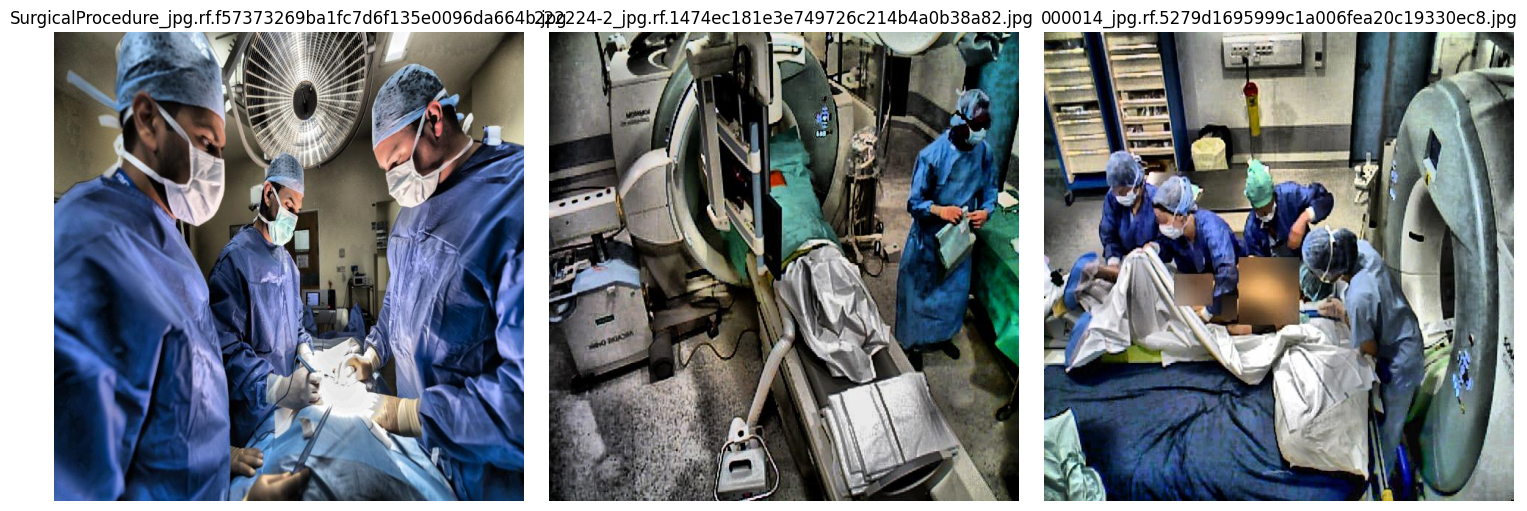

Processing 240 training images...


100%|██████████| 240/240 [00:01<00:00, 133.80it/s]


Processing 30 test images...


100%|██████████| 30/30 [00:00<00:00, 135.84it/s]


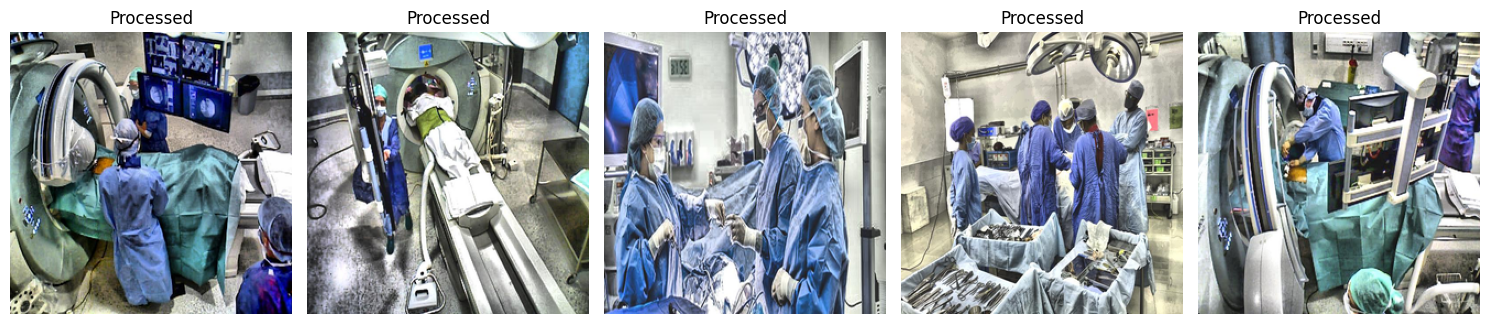

Training images processed: 240
Test images processed: 54
Preprocessing complete. Images saved to preprocessed_or_images


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from roboflow import Roboflow

# Code provided by Roboflow to load dataset
rf = Roboflow(api_key="uZvyIP0TCztJgFW16Gr2")
project = rf.workspace("paob").project("face-detection-operating-room-v9hko")
version = project.version(1)
dataset = version.download("coco")
input_dir = dataset.location 
print(f"Dataset downloaded to: {input_dir}")

# Define output directories
output_dir = "preprocessed_or_images"
os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Find image directories in the dataset
def find_image_directories(dataset_dir):
    """Find directories containing images in the dataset structure"""
    image_dirs = []
    potential_dirs = ["train", "valid", "test", "images"]
    
    # Check for known directory names
    for dir_name in potential_dirs:
        dir_path = os.path.join(dataset_dir, dir_name)
        if os.path.isdir(dir_path):
            image_dirs.append(dir_path)
    
    return image_dirs

# Get all images from the dataset
image_dirs = find_image_directories(input_dir)
print(f"Found {len(image_dirs)} directories with images:")
for dir_path in image_dirs:
    print(f"  - {dir_path}")

# Collect all image files
image_files = []
train_files = []
test_files = []

# Sort images into train and test based on directory names; robofow splits this for you on website so its already split
for image_dir in image_dirs:
    dir_name = os.path.basename(image_dir).lower()
    files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) 
             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if 'train' in dir_name:
        train_files.extend(files)
    elif 'test' in dir_name or 'valid' in dir_name:
        test_files.extend(files)
    else:
        image_files.extend(files)

# Function to preprocess and resize images; roboflow also flips, rotates, and augments images so none of that specified here
def preprocess_image(image_path, target_size=(256, 256)):
    try:
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(target_size, Image.LANCZOS)
        img_array = np.array(img)
        
        return img_array, True
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, False

# Display sample images
if train_files:
    print("Sample images from the dataset:")
    sample_indices = np.random.choice(len(train_files), min(3, len(train_files)), replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices):
        img_path = train_files[idx]
        try:
            img = Image.open(img_path)
            plt.subplot(1, 3, i+1)
            plt.imshow(np.array(img))
            plt.title(os.path.basename(img_path))
            plt.axis('off')
        except Exception as e:
            print(f"Error displaying {img_path}: {e}")
    plt.tight_layout()
    plt.show()

# Process training images
processed_images = []
print(f"Processing {len(train_files)} training images...")
for i, img_path in enumerate(tqdm(train_files)):
    img_array, success = preprocess_image(img_path)
    if success:
        output_filename = f"or_image_{i:04d}.jpg"
        output_path = os.path.join(train_dir, output_filename)
        Image.fromarray(img_array).save(output_path)
        
        # Keep a few for visualization
        if i < 5:
            processed_images.append(img_array)

# Process test images
print(f"Processing {len(test_files)} test images...")
for i, img_path in enumerate(tqdm(test_files)):
    img_array, success = preprocess_image(img_path)
    if success:
        output_filename = f"or_image_{i:04d}.jpg"
        output_path = os.path.join(test_dir, output_filename)
        Image.fromarray(img_array).save(output_path)

# Display processed images
if processed_images:
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(processed_images))):
        plt.subplot(1, 5, i+1)
        plt.imshow(processed_images[i])
        plt.title("Processed")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Data distribution
train_count = len(os.listdir(train_dir))
test_count = len(os.listdir(test_dir))
print(f"Training images processed: {train_count}")
print(f"Test images processed: {test_count}")
print(f"Preprocessing complete. Images saved to {output_dir}")